# 1)Transformations

In [1]:
#Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import sys

(154, 620, 3)

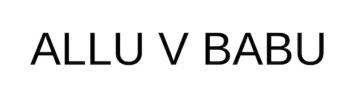

In [2]:
image = plt.imread("name_image.jpg")
plt.imshow(image)
plt.axis("off")
image.shape

# Forward Mapping

In [3]:
def ICV_get_tranformed_image_size(image, transformational_matrix):
    """
    param image : Image that has to be transformed
    param tranformational_matrix : Matrix formulation of the tranformation that has to be applied to the image
    Returns : The number of rows and columns of the image after applying transformation
    """
    #Finding the center of the image
    x_center = image.shape[1] // 2
    y_center = image.shape[0] // 2
    
    #Setting maximum and minimum of axis values to minimum and maximum respectively
    min_x = sys.maxsize
    max_x = -sys.maxsize-1
    min_y = sys.maxsize
    max_y = -sys.maxsize-1
    
    #Iterating through each pixel of the image
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            
            #Pixel with respect to the center of the image
            coordinates = np.array([j-x_center, i-y_center])
            
            #Applying transformation to the pixel with respect to the center of the image
            transformed_coordinates = transformational_matrix @ coordinates
            
            new_row = int(np.round(transformed_coordinates[1]))
            new_col = int(np.round(transformed_coordinates[0]))            
            
            if new_row < min_x:
                min_x = new_row
            if new_row > max_x:
                max_x = new_row
            if new_col < min_y:
                min_y = new_col
            if new_col > max_y:
                max_y = new_col
    #New size of the image will be the difference of maximum and minimum values of the axes           
    new_x = max_x - min_x
    new_y = max_y - min_y
    
    return new_x, new_y

In [4]:
def ICV_get_skew_matrix(theta):
    """
    param : theta
    Returns : The matrix formulation for applying skew transformation to an image
    """
    return np.array([[1, -np.tan(theta)],
        [0, 1]])

In [5]:
def ICV_get_rotational_matrix(theta):
    """
    param : theta
    Returns : The matrix formulation for applying rotation to an image
    """
    return np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]])

In [6]:
def ICV_transform_image_forward(image, theta, transformational_matrix):
    """
    param image : Image that needs to be transformed
    param theta : Angle in randians by which image has to be transformed
    param transformational_matrix : Matrix formulation for the tranformation that has to be applied to the image
    Returns : The image after transformation by the transformational matrix bu an angle theta
    """
    #Finding the center of the original image
    x_center = image.shape[1] // 2
    y_center = image.shape[0] // 2

    #Getting the size of image after transformation
    new_x, new_y = ICV_get_tranformed_image_size(image, transformational_matrix)
    
    #Initializing a transformed image with the size obtained in previous step with black pixels
    transformed_image = np.zeros((new_x+1,new_y+1,3))
    
    #Finding the center of the transformed image
    transformed_x_center = transformed_image.shape[1]//2
    transformed_y_center = transformed_image.shape[0]//2
    
    #Iterating through each pixel of the original image
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            
            #Pixel with respect to the center of the image
            coordinates = np.array([j - x_center, i - y_center])
            
            #Applying transformation to the pixel with respect to the center of the image
            transformed_coordinates = transformational_matrix @ coordinates
           
            #Translating back with respect to the center of the image
            transformed_coordinates = transformed_coordinates + np.array([transformed_x_center,transformed_y_center])
            
            y_transformed = int(np.round(transformed_coordinates[0]))
            x_transformed = int(np.round(transformed_coordinates[1]))
            
            #Storing the pixel obtained after transformation in the transformed_image array
            transformed_image[x_transformed, y_transformed, :] = image[i, j, :]
            
    return transformed_image.astype(int)
    

In [7]:
def ICV_rotate_image_forward(image, angle_degrees):
    """
    param image: Image that has to be rotated
    param angle_degrees : Angle in degrees by which the image needs to be rotated
    Returns : The rotated image after doing forward mapping
    """
    #Converting angles in degrees to radians
    theta = np.radians(angle_degrees)
    
    #Getting the rotational matrix
    rotational_matrix = ICV_get_rotational_matrix(theta)
    
    rotated_image = ICV_transform_image_forward(image, theta, rotational_matrix)
    return rotated_image

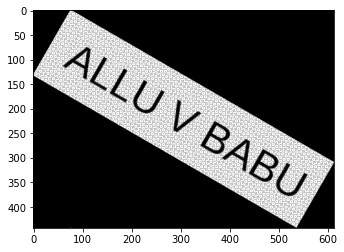

In [8]:
#Trying out rotation by forward mapping
rotated_image = ICV_rotate_image_forward(image, 30)
plt.imshow(rotated_image )

In [9]:
def ICV_skew_image_forward(image, angle_degrees):
    """
    param image : Image that has to be skewed
    param angle_degrees : Angle in degrees by which the image needs to be skewed
    Returns : The skewed image after doing forward mapping 
    """
    #Converting angles in degrees to radians
    theta = np.radians(angle_degrees)
    
    #Getting the skew matrix
    skew_matrix = ICV_get_skew_matrix(theta)
    
    skewed_image = ICV_transform_image_forward(image, theta, skew_matrix)
    return skewed_image

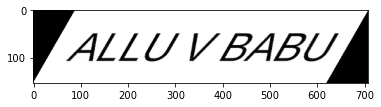

In [10]:
#Trying out skewing by forward mapping
skewed_image = ICV_skew_image_forward(image, 30)
plt.imshow(skewed_image)

## Inverse Mapping

Trying inverse mapping as the image obtained by forward mapping has a lot of holes

In [11]:
def ICV_transform_image_inverse(image, theta, transformational_matrix, mode, transformation):
    """
    param image : Image that needs to be transformed
    param theta : Angle in randians by which image has to be transformed
    param transformational_matrix : Matrix formulation for the tranformation that has to be applied to the image
    param mode : The type of inverse mapping Bilinear Interpolation or nearest neighbour interpolation
    param transformation : The tranformation type that has to be applied on the image rotation or skew
    Returns : The image after transformation by the transformational matrix bu an angle theta
    """
    
    #Finding the center of the image
    x_center = int(image.shape[1]/2.0)
    y_center = int(image.shape[0]/2.0)
    
    #Finding the transpose of the rotated image as inverse is being performed
    #if transformation == "rotation":
     #   transformational_matrix = (transformational_matrix).T

    #Finding the size of the transformed image
    x_size, y_size = ICV_get_tranformed_image_size(image, transformational_matrix)
    
    #Initializing a transformed image with the size obtained in previous step with black pixels
    transformed_image = np.zeros((int(x_size)+1,int(y_size)+1,3))
    
    #Finding the center of the transformed image
    transformed_x_center = int(transformed_image.shape[1]/2.0)
    transformed_y_center = int(transformed_image.shape[0]/2.0)
    
    #Iterating through each pixel of the transformed image
    for i in range(transformed_image.shape[0]):
        for j in range(transformed_image.shape[1]):
            
            #If the pixel is the centre pixel of the transformed image nothing is done
            if(i == transformed_y_center and j == transformed_x_center):
                continue
            
            #Pixel with respect to the center of the image
            transformed_cordinates = np.array([j - transformed_x_center, i - transformed_y_center])
            
            #Applying transformation to the pixel
            old_coordinate = np.matmul(transformational_matrix, transformed_cordinates)
            
            #Translating back with respect to the center of the image
            old_coordinate = old_coordinate + np.array([x_center,y_center])
            
            x = int(np.round(old_coordinate[1]))
            y = int(np.round(old_coordinate[0]))
            
            #Implementing nearest neighbour interpolation
            if mode == "Nearest Neighbour":
                #If the coordinates obtained by doing inverse mapping are not in the image nothing is done
                if y >= image.shape[1] or x >=image.shape[0] or np.sum(old_coordinate < 0):
                    continue
                
                #Storing the pixel obtained after transformation in the transformed_image array
                transformed_image[i,j,:] = image[x,y,:]
            
            #Implementing the bilinear interpolation#
            elif mode == "Bilinear Interpolation":
                x1 = int(np.floor(old_coordinate[0]))
                x2 = int(np.ceil(old_coordinate[0]))
                y1 = int(np.floor(old_coordinate[1]))
                y2 = int(np.ceil(old_coordinate[1]))
                x0 = old_coordinate[0]
                y0 = old_coordinate[1]
                
                #if the points x1, x2, y1, y2 are outside the image notthing is done
                if(x1 < 0 or x2 >= image.shape[1]) or (y1 < 0 or y2 >= image.shape[0]):
                    continue
                
                #Finding known values of image surrounding the unknown pixel
                fQ11 = image[y1, x1, :]
                fQ12 = image[y2, x1, :]
                fQ21 = image[y1, x2, :]
                fQ22 = image[y2, x2, :]
                
                if transformation == "rotation":
                    
                    if(x1 == x2):
                        fR1 = fQ11
                        fR2 = fQ22
                    else:
                        #Doing bilinear interpolation for the pixels
                        fR1 = (x2 - x0) / (x2 - x1) * fQ11 + (x0 - x1) / (x2 - x1) * fQ21
                        fR2 = (x2 - x0) / (x2 - x1) * fQ12 + (x0 - x1) / (x2 - x1) * fQ22
                    
                    if(y1 == y2):
                        transformed_image[i, j, :] = fR1
                    else:
                        transformed_image[i, j, :] = (y2 - y0) / (y2 - y1) * fR1 + (y0 - y1) / (y2 - y1) * fR2
              
                if transformation == "skew":
                    if i == transformed_y_center:
                        #If the coordinates obtained by doing inverse mapping are not in the image nothing is done
                        if(x >= image.shape[0] or y >= image.shape[1]):
                            continue
                        
                        #Storing the pixel obtained after transformation in the transformed_image array
                        transformed_image[i, j, :] = image[x, y, :]
                        continue
                    #Storing the pixel obtained after interpolation in the transformed_image array    
                    transformed_image[i, j, :] = (x2 - x0) / (x2 - x1) * fQ11 + (x0 - x1) / (x2 - x1) * fQ21             
            
    return transformed_image.astype(int)

In [12]:
def ICV_get_rotational_matrix(theta):
    """
    param : theta
    Returns : The matrix formulation for applying rotation to an image
    """
    return np.array([[np.cos(theta), np.sin(theta)],
                    [-np.sin(theta), np.cos(theta)]])

In [13]:
def ICV_get_skew_matrix(theta):
    return np.array([
        [1, np.tan(theta)],
        [0, 1]])
        

In [14]:
def ICV_rotate_image_inverse(image, angle_degrees, mapping):
    """
    param image: Image that has to be rotated
    param angle_degrees : Angle in degrees by which the image needs to be rotated
    param mapping : The type of the interpolation that needs to be done
    Returns : The rotated image after doing forward mapping
    """
    theta = np.radians(angle_degrees)
    rotational_matrix = ICV_get_rotational_matrix(theta)
    rotated_image = ICV_transform_image_inverse(image, theta, rotational_matrix, mapping, "rotation")
    return rotated_image

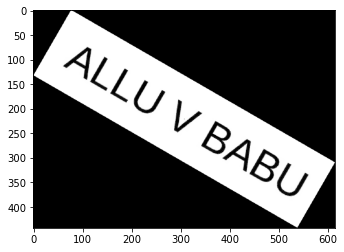

In [15]:
#Trying out rotation by nearest neighbour interpolation
nearest_nn_rotated_image = ICV_rotate_image_inverse(image, 30, "Nearest Neighbour")
plt.imshow(nearest_nn_rotated_image)

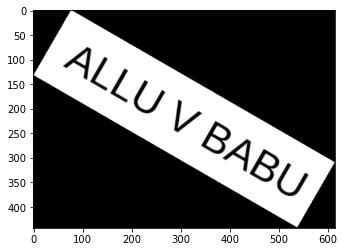

In [16]:
#Trying out rotation by bilinear interpolation
bilinear_rotated_image = ICV_rotate_image_inverse(image, 30, "Bilinear Interpolation")
plt.imshow(bilinear_rotated_image)

In [17]:
def ICV_skew_image_inverse(image, angle_degrees, mapping):
    """
    param image : Image that has to be skewed
    param angle_degrees : Angle in degrees by which the image needs to be skewed
    param mapping : The type of the interpolation that needs to be done
    Returns : The skewed image after doing forward mapping 
    """
    theta = np.radians(angle_degrees)
    skew_matrix = ICV_get_skew_matrix(theta)
    skewed_image = ICV_transform_image_inverse(image, theta, skew_matrix, mapping, "skew")
    return skewed_image

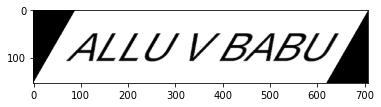

In [18]:
#Trying skew by nearest neighbour
nearest_nn_skewed_image = ICV_skew_image_inverse(image, 30, "Nearest Neighbour")
plt.imshow(nearest_nn_skewed_image)

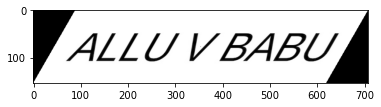

In [19]:
#Trying skew by bilinear interpolation
bilinear_skewed_image  = ICV_skew_image_inverse(image, 30, "Bilinear Interpolation")
plt.imshow(bilinear_skewed_image)

<b>a) Write a function that takes as input an image I, rotates it by an angle θ1 and horizontally skews it by an angle, θ2. Write the matrix formulation for image rotation R(.) and skewing S(.). Define all the variables. Note that the origin of the coordinate system of the programming environment you use might be different from the one shown in the lectures.</b>

Three methods for doing rotation and skew of the matrix has been tried. Forward mapping for rotation was found to have a lot of holes as we were only trying to map the pixels in the original image to the transformed image. Inverse mapping by bilinear interpolation and nearest neighbour was tried after that and was found to yield better results

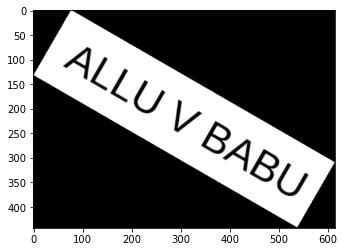

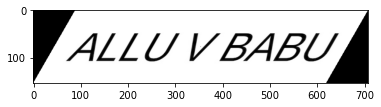

In [20]:
#Using the bilinear interpolation for rotation and skew
bilinear_rotated_image = ICV_rotate_image_inverse(image, 30, "Bilinear Interpolation")
plt.imshow(bilinear_rotated_image)
plt.show()

bilinear_skewed_image  = ICV_skew_image_inverse(image, 30, "Bilinear Interpolation")
plt.imshow(bilinear_skewed_image)
plt.show()


<B>b) Create an image that contains your name written in Arial, point 72, capital letters. Rotate clockwise the image you created by 30, 60, 120 and -50 degrees. Skew the same image by 10, 40 and 60 degrees. Complete the process so that all the pixels have a value. Discuss in the report the advantages and disadvantages of different approaches.</B>

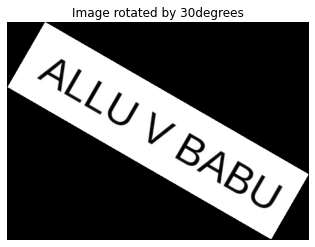

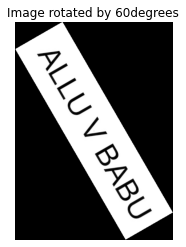

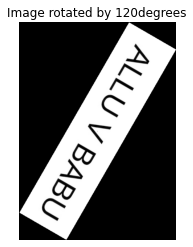

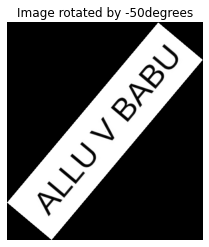

In [21]:
rotational_angles = [30, 60, 120, -50]
for angle in rotational_angles:
    rotated_image = ICV_rotate_image_inverse(image, angle, "Bilinear Interpolation")
    plt.imshow(rotated_image)
    plt.axis("off")
    plt.title("Image rotated by " + str(angle) + "degrees")
    plt.show()
    

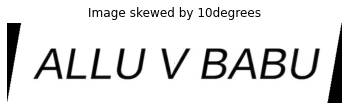

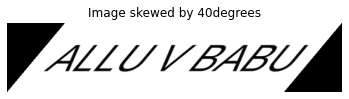

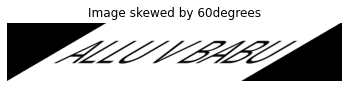

In [22]:
skew_angles = [10, 40, 60]
for angle in skew_angles:
    rotated_image = ICV_skew_image_inverse(image, angle, "Bilinear Interpolation")
    plt.imshow(rotated_image)
    plt.axis("off")
    plt.title("Image skewed by " + str(angle) + "degrees")
    plt.show()
    

<b>c) Analyse the results when you change the order of the two operators: R(S(I)) and S(R(I)).
i) Rotate the image by θ1 = 20 clockwise and then skew the result by θ2 = 50.
ii) Skew the image by θ2 = 50 and then rotate the result by θ1 = 20 clockwise.
Are the results of (i) and (ii) the same? Why?</b>

i)

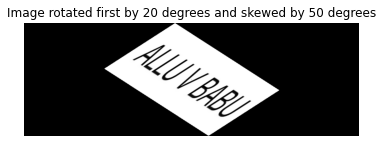

In [23]:
rotated_image = ICV_rotate_image_inverse(image, 20, "Bilinear Interpolation")
skewed_image = ICV_skew_image_inverse(rotated_image, 50, "Bilinear Interpolation")
plt.imshow(skewed_image)
plt.axis("off")
plt.title("Image rotated first by 20 degrees and skewed by 50 degrees")
plt.show()


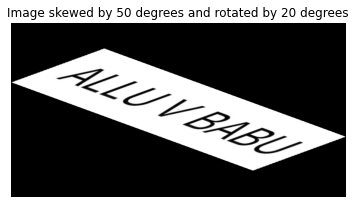

In [24]:
skewed_image = ICV_skew_image_inverse(image, 50, "Bilinear Interpolation")
rotated_image = ICV_rotate_image_inverse(skewed_image, 20, "Bilinear Interpolation")

plt.imshow(rotated_image)
plt.axis("off")
plt.title("Image skewed by 50 degrees and rotated by 20 degrees")
plt.show()